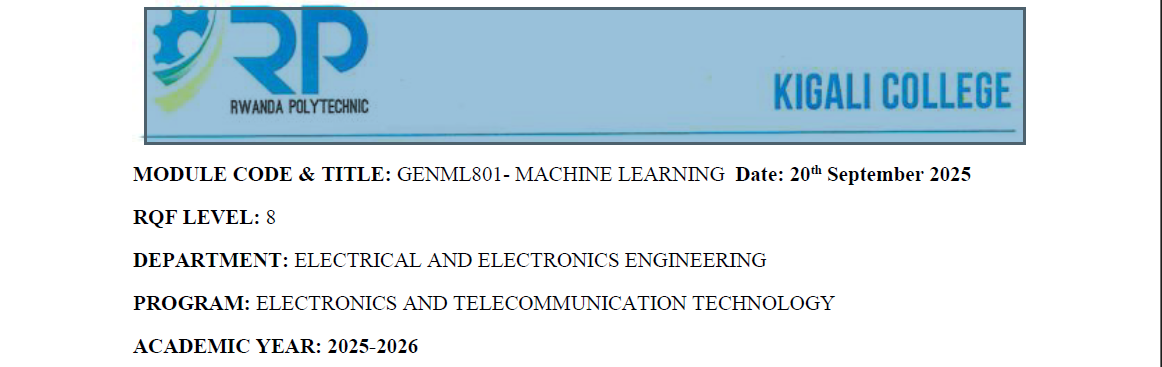

## Names:Kwizera Ndatsikira Iness
## Reg no: 25RP20020


This notebook performs EDA, feature engineering, model training, and evaluation (including confusion matrix) using the `approved` column as the target.

## Import libraries and Load dataset

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("sacco_loan_dataset.csv")
df.head()


,borrower_id,age,gender,marital_status,education_level,monthly_income,loan_amount,loan_term_months,employment_status,past_repayment_history,savings_balance,loan_default
0,1,59,Female,Single,Tertiary,34809,421923,18,Employed,Good,232732,1
1,2,49,Female,Married,Primary,193273,449384,24,Employed,Poor,909827,0
2,3,35,Male,Divorced,Primary,214402,682387,12,Unemployed,Average,669648,0
3,4,28,Female,Married,Primary,174528,581849,36,Self-employed,Good,613474,0
4,5,41,Male,Divorced,Tertiary,479613,517010,12,Employed,Good,924044,1


## Exploratory Data Analysis (EDA)

In [2]:

# Dataset shape and info
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

# Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Value counts for target 'approved'
print("\nTarget distribution:")
print(df['loan_default'].value_counts())

# Describe numerical features
df.describe().T


Shape: (200, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   borrower_id             200 non-null    int64 
 1   age                     200 non-null    int64 
 2   gender                  200 non-null    object
 3   marital_status          200 non-null    object
 4   education_level         200 non-null    object
 5   monthly_income          200 non-null    int64 
 6   loan_amount             200 non-null    int64 
 7   loan_term_months        200 non-null    int64 
 8   employment_status       200 non-null    object
 9   past_repayment_history  200 non-null    object
 10  savings_balance         200 non-null    int64 
 11  loan_default            200 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 18.9+ KB
None

Missing values per column:
borrower_id               0
age                       0
gen

,count,mean,std,min,25%,50%,75%,max
borrower_id,200.0,100.500,57.879185,1.0,50.75,100.5,150.25,200.0
age,200.0,40.045,11.826339,21.0,29.00,41.5,50.00,59.0
monthly_income,200.0,261454.340,133842.934862,31062.0,147466.00,272009.0,375451.75,493389.0
loan_amount,200.0,410315.610,212979.288395,51917.0,208441.25,417934.0,585819.25,793246.0
loan_term_months,200.0,18.600,10.470346,6.0,12.00,18.0,24.00,36.0
savings_balance,200.0,538899.650,282981.982449,6154.0,290562.00,574388.0,777488.50,994762.0
loan_default,200.0,0.300,0.459408,0.0,0.00,0.0,1.00,1.0


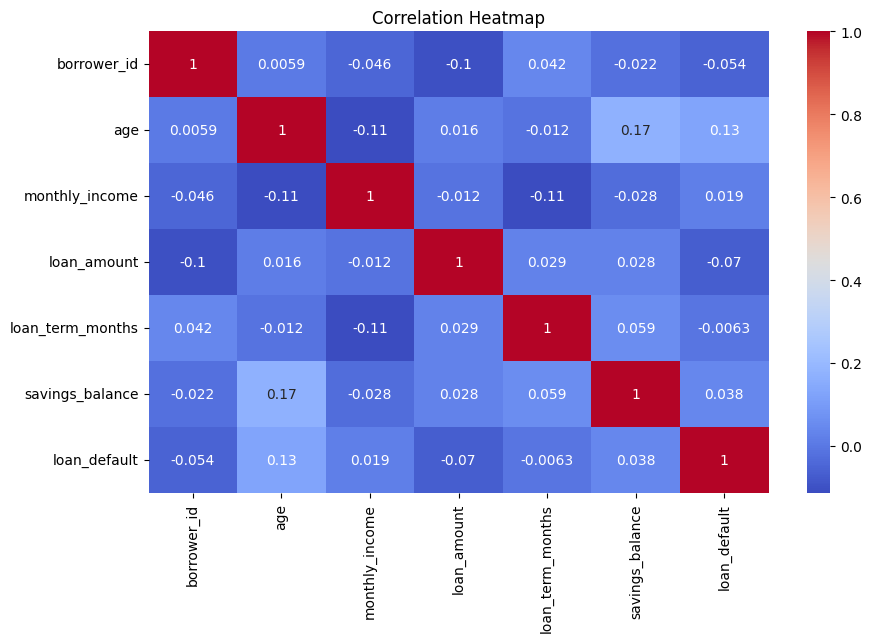

In [3]:

# Correlation heatmap for numeric features
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## Feature Engineering and Preprocessing

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['loan_default'])
y = df['loan_default']

# Encode target if not numeric
if y.dtype == 'O' or y.dtype == object:
    le_target = LabelEncoder()
    y = le_target.fit_transform(y.astype(str))
else:
    le_target = None

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])


## Model Training

In [5]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['borrower_id', 'age',
                                                   'monthly_income',
                                                   'loan_amount',
                                                   'loan_term_months',
                                                   'savings_balance']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'marital_status',
                                                   'education_level',
                                                   'employment_status',
                                                   'past_repayment_history'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

## Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        28
           1       1.00      0.08      0.15        12

    accuracy                           0.72        40
   macro avg       0.86      0.54      0.49        40
weighted avg       0.80      0.72      0.63        40



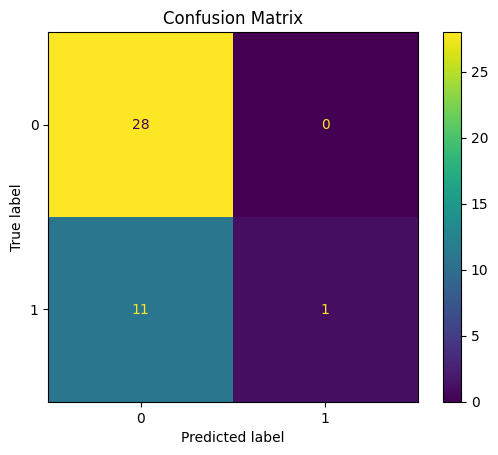

In [6]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()


## Save Model for Deployment

In [7]:

import joblib

joblib.dump({
    "pipeline": clf,
    "label_encoder_target": le_target,
    "feature_columns": X.columns.tolist()
}, "model_pipeline.joblib")

print("Model saved to model_pipeline.joblib")


Model saved to model_pipeline.joblib
